In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn import model_selection, preprocessing, metrics
import warnings
import datetime
import os

from sklearn.linear_model import ElasticNet, Lasso, LassoLars, Ridge

/Users/dims/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train = pd.read_csv('train.csv', parse_dates=['first_active_month'])
df_test = pd.read_csv('test.csv', parse_dates=['first_active_month'])
print(df_train.shape)
print(df_test.shape)

(201917, 6)
(123623, 5)


In [4]:
df_train['day'] = df_train['first_active_month'].dt.day
df_test['day'] = df_test['first_active_month'].dt.day
df_train['month'] = df_train['first_active_month'].dt.month
df_test['month'] = df_test['first_active_month'].dt.month
df_train['year'] = df_train['first_active_month'].dt.year
df_test['year'] = df_test['first_active_month'].dt.year
df_train['elapsed_time'] = (datetime.date(2018, 2, 1) - df_train['first_active_month'].dt.date).dt.days
df_test['elapsed_time'] = (datetime.date(2018, 2, 1) - df_test['first_active_month'].dt.date).dt.days

In [5]:
# df_train['feature_2_enc'] = df_train.groupby('feature_2')['target'].transform('mean')
# np.corrcoef(df_train['feature_2_enc'].values, df_train.target.values)

In [6]:
df_train = pd.get_dummies(df_train, columns=['feature_1', 'feature_2'])
df_test = pd.get_dummies(df_test, columns=['feature_1', 'feature_2'])
df_test.head()

,first_active_month,card_id,feature_3,day,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3
0,2017-04-01,C_ID_0ab67a22ab,1,1.0,4.0,2017.0,306.0,0,0,1,0,0,0,0,1
1,2017-01-01,C_ID_130fd0cbdd,0,1.0,1.0,2017.0,396.0,0,1,0,0,0,0,0,1
2,2017-08-01,C_ID_b709037bc5,1,1.0,8.0,2017.0,184.0,0,0,0,0,1,1,0,0
3,2017-12-01,C_ID_d27d835a9f,0,1.0,12.0,2017.0,62.0,0,1,0,0,0,1,0,0
4,2015-12-01,C_ID_2b5e3df5c2,1,1.0,12.0,2015.0,793.0,0,0,0,0,1,1,0,0


In [7]:
df_hist_trans = pd.read_csv('historical_transactions.csv', parse_dates=['purchase_date'])
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
df_hist_trans = pd.get_dummies(df_hist_trans, columns=['category_2', 'category_3'])
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0


In [9]:
df_new_trans= pd.read_csv("new_merchant_transactions.csv", parse_dates=['purchase_date'])
df_new_trans.sample(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
1145577,Y,C_ID_9215b1236b,143,N,0,A,307,M_ID_674aee6c40,2,-0.686802,2018-04-23 14:44:12,5.0,5,19
415099,Y,C_ID_e2fb230c8a,161,N,1,B,278,M_ID_6b5a03e868,1,-0.681452,2018-03-13 13:47:57,3.0,3,37
1275263,Y,C_ID_6cb804d1a5,69,N,0,A,561,M_ID_50f575c681,1,-0.634209,2018-03-24 10:47:32,1.0,9,7
472092,Y,C_ID_529ec32e80,137,N,0,A,529,M_ID_0d58d5cf32,1,-0.521510,2018-03-21 08:48:44,3.0,19,20
1209126,Y,C_ID_11aa4de4cf,170,N,1,B,307,M_ID_34bb3dbcab,1,-0.671775,2018-03-05 16:45:04,3.0,8,19


In [10]:
df_new_trans = pd.get_dummies(df_new_trans, columns=['category_2', 'category_3'])
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'Y': 1, 'N': 0})
df_new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,9,19,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,9,19,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,9,14,1,0,0,0,0,0,1,0
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1,8,0,0,0,0,0,0,1,0
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1,29,0,0,0,0,0,0,1,0


In [11]:
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_trans = reduce_mem_usage(df_new_trans)

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)


In [12]:
df_hist_trans['purchase_month'] = df_hist_trans['purchase_date'].dt.month
df_new_trans['purchase_month'] = df_new_trans['purchase_date'].dt.month

In [13]:
def aggregate_transaction(trans, prefix):
    trans.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans['purchase_date']).astype(np.int64) * 1e-9
    agg_func = {
        'authorized_flag': ['sum', 'median', 'mean'],
        'category_1': ['median', 'mean', 'sum'],
        'category_2_1.0': ['median', 'mean'],
        'category_2_2.0': ['median', 'mean'],
        'category_2_3.0': ['median', 'mean'],
        'category_2_4.0': ['median', 'mean'],
        'category_2_5.0': ['median', 'mean'],
        'category_3_A': ['median', 'mean'],
        'category_3_B': ['median', 'mean'],
        'category_3_C': ['median', 'mean'],
        'merchant_id': ['nunique', 'count'],
        'merchant_category_id': ['nunique', 'count'], # NEW
        'state_id': ['nunique', 'count'], # NEW
        'subsector_id': ['nunique', 'count'], # NEW
        'city_id': ['nunique', 'count'], # NEW
        'installments': ['count', 'sum', 'median', 'mean', 'max', 'min', 'std'],
        'purchase_amount': ['count', 'sum', 'median', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['count', 'median', 'mean', 'max', 'min', 'std'], # NEW
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['count', 'min', 'max', 'std', 'mean', 'median'],   
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
         .size()
         .reset_index(name='{}transactions_count'.format(prefix))
         )
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [14]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'median', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'median', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)
    
    final_group = intermediate_group.groupby('card_id').agg(['median', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

In [15]:
import gc
merch_hist = aggregate_transaction(df_hist_trans, prefix='hist_')
merch_hist_m = aggregate_per_month(df_hist_trans)
del df_hist_trans
gc.collect()
df_train = pd.merge(df_train, merch_hist, on='card_id', how='left')
df_train = pd.merge(df_train, merch_hist_m, on='card_id', how='left')
df_test = pd.merge(df_test, merch_hist, on='card_id', how='left')
df_test = pd.merge(df_test, merch_hist_m, on='card_id', how='left')
del merch_hist, merch_hist_m
gc.collect()
df_train.sample(5)

,first_active_month,card_id,feature_3,target,day,month,year,elapsed_time,feature_1_1,feature_1_2,...,installments_median_median,installments_median_std,installments_mean_median,installments_mean_std,installments_min_median,installments_min_std,installments_max_median,installments_max_std,installments_std_median,installments_std_std
90644,2017-10-01,C_ID_984c86d698,1,1.582047,1,10,2017,123,0,0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
173690,2017-07-01,C_ID_314959e5c6,1,0.080100,1,7,2017,215,0,0,...,0.0,0.0,0.000000,0.011785,0.0,0.000000,0.0,0.353553,0.000000,0.064550
71069,2017-05-01,C_ID_a285d706f8,1,1.141361,1,5,2017,276,0,0,...,1.0,0.0,1.032258,0.209568,1.0,0.843274,2.0,2.884826,0.331125,0.644988
90198,2017-01-01,C_ID_d03ea491a6,1,-0.087916,1,1,2017,396,0,0,...,0.0,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.500000,0.000000,0.188982
105317,2017-12-01,C_ID_730ce135cc,0,1.193515,1,12,2017,62,0,0,...,1.0,0.0,1.000000,0.000000,1.0,0.000000,1.0,0.000000,0.000000,0.000000


In [16]:
merch_new = aggregate_transaction(df_new_trans, prefix='new_')
# merch_new_m = aggregate_per_month(df_new_trans)
del df_new_trans
gc.collect()
df_train = pd.merge(df_train, merch_new, on='card_id', how='left')
# df_train = pd.merge(df_train, merch_new_m, on='card_id', how='left')
df_test = pd.merge(df_test, merch_new, on='card_id', how='left')
# df_test = pd.merge(df_test, merch_new_m, on='card_id', how='left')
del merch_new
gc.collect()
df_train.sample(5)

,first_active_month,card_id,feature_3,target,day,month,year,elapsed_time,feature_1_1,feature_1_2,...,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_count,new_month_lag_min,new_month_lag_max,new_month_lag_std,new_month_lag_mean,new_month_lag_median
176821,2017-09-01,C_ID_4a3812a7e1,1,-0.236170,1,9,2017,153,0,0,...,0.500000,4753555.0,1.520015e+09,1.524769e+09,4.0,1.0,2.0,0.500000,1.250000,1.0
69107,2016-01-01,C_ID_0dcf633ea7,0,0.056495,1,1,2016,762,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188398,2017-09-01,C_ID_96ee77b508,1,-1.346495,1,9,2017,153,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5118,2017-05-01,C_ID_856e813823,0,0.606835,1,5,2017,276,0,1,...,0.577350,3287466.0,1.521119e+09,1.524406e+09,3.0,1.0,2.0,0.577350,1.333333,1.0
133524,2017-05-01,C_ID_eb82256066,1,1.683006,1,5,2017,276,0,0,...,0.547723,1346417.0,1.521744e+09,1.523091e+09,5.0,1.0,2.0,0.547723,1.400000,1.0


In [17]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)
df_train[features].head()

,feature_3,day,month,year,elapsed_time,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,...,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_count,new_month_lag_min,new_month_lag_max,new_month_lag_std,new_month_lag_mean,new_month_lag_median
0,1,1,6,2017,245,0,0,0,0,1,...,0.510754,4742309.0,1.520259e+09,1.525001e+09,23.0,1.0,2.0,0.510754,1.478261,1.0
1,0,1,1,2017,396,0,0,0,1,0,...,0.547723,4887632.0,1.517505e+09,1.522393e+09,6.0,1.0,2.0,0.547723,1.500000,1.5
2,0,1,8,2016,549,0,1,0,0,0,...,NaN,0.0,1.524937e+09,1.524937e+09,1.0,2.0,2.0,NaN,2.000000,2.0
3,0,1,9,2017,153,0,0,0,1,0,...,0.487950,3625505.0,1.520424e+09,1.524049e+09,7.0,1.0,2.0,0.487950,1.714286,2.0
4,0,1,11,2017,92,1,0,0,0,0,...,0.503953,4949682.0,1.519992e+09,1.524941e+09,36.0,1.0,2.0,0.503953,1.555556,2.0


In [18]:
print(df_train[features].shape)
print(df_test[features].shape)

(201917, 167)
(123623, 167)


In [40]:
param = {'num_leaves': 100,
        'min_data_in_leaf': 30,
        'objective': 'regression',
        'max_depth': 12, 
        'learning_rate': 0.005, 
        'boosting': 'gbdt', 
        'feature_fraction': 0.9, 
        'bagging_freq': 1, 
        'bagging_fraction': 0.9,
        'bagging_seed': 11,
        'metric': 'rmse', 
        'lambda_l1': 0.1, 
        'verbosity': -1
        }

folds = KFold(n_splits=10, random_state=150)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

tst_data = df_test[features]
tst_data.fillna((tst_data.mean()), inplace=True)
tst_data = tst_data.values

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    
    trn_data, trn_y = df_train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = df_train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values
    
    clf = Ridge(random_state=150, alpha=1)
    clf.fit(trn_data, trn_y)
    
    oof[val_idx] = clf.predict(val_data)
    predictions += clf.predict(tst_data) / folds.n_splits

/Users/dims/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


-
Fold 1
-
Fold 2
-
Fold 3
-
Fold 4


/Users/dims/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.239871e-20
  overwrite_a=True).T


-
Fold 5
-
Fold 6


/Users/dims/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.238896e-20
  overwrite_a=True).T


-
Fold 7
-
Fold 8
-
Fold 9
-
Fold 10


In [24]:
from sklearn.metrics import mean_squared_error
val_score = np.sqrt(mean_squared_error(target, oof))
val_score

3.663752476986471

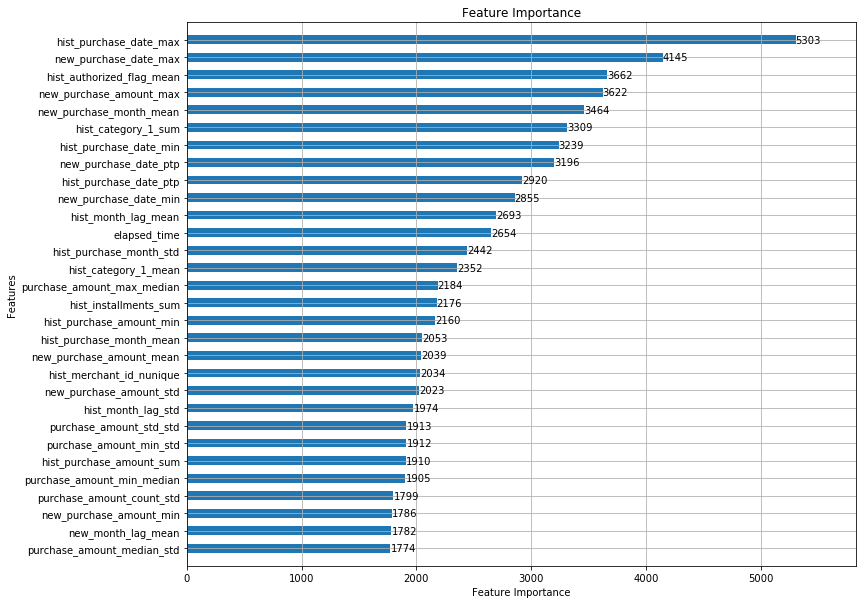

In [25]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(clf, max_num_features=30, height=0.5, ax=ax, 
                    title="Feature Importance", xlabel='Feature Importance', ylabel='Features')
plt.show()

In [26]:
df_sub = pd.DataFrame({'card_id': df_test['card_id'].values})
df_sub['target'] = predictions
df_sub.to_csv("sub_val_{}.csv".format(val_score), index=False)

# submit yg 3.678 & 
# try RGF (regularized gradient forest)
# try RidgeCV or LassoCV